# ベイズ推論による機械学習 第4章
混合モデルについて

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

import numpy as np
from scipy import stats
from PIL import Image, ImageDraw

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
IMG_PATH = "images/chapter_4/"

# ガウス混合分布

## ギブスサンプリング

In [6]:
np.random.rand()

0.5345391525318322

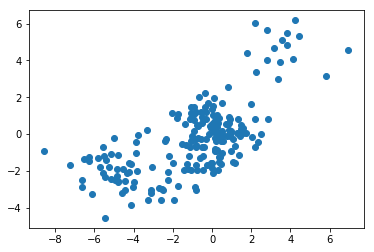

In [18]:
# 対象データ
N = 200
X = []
for i in range(N):
    rand = np.random.rand()
    if rand < 0.1:
        true_m = np.array([[4, 4]], dtype = 'float64')
        true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    elif rand < 0.4:
        true_m = np.array([[-4, -2]], dtype = 'float64')
        true_sigma = np.array([[3, 0], [0, 1]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    else:
        true_m = np.array([[0, 0]], dtype = 'float64')
        true_sigma = np.array([[1, 0], [0, 1]], dtype = 'float64')
        x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
    X.append(x)
X = np.array(X) 
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [713]:
def sample_gmm(N):
    sample = []
    for i in range(N):
        rand = np.random.rand()
        if rand < 0.1:
            true_m = np.array([[4, -4]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        elif rand < 0.3:
            true_m = np.array([[-4, -4]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        else:
            true_m = np.array([[0, 0]], dtype = 'float64')
            true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
            x = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=1)
        sample .append(x)
    sample  = np.array(sample ) 
#     plt.scatter(sample [:, 0], sample [:, 1])
#     plt.show()
    return sample

In [714]:
mu_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("mu_s", mu_s); print()

lam_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("lam_s", lam_s); print()

m_s = np.array([[0, 0], [1, 1], [-1, -1]])
print("m_s", m_s); print()

beta = np.ones(3)
print("beta", beta); print()

nu_s = np.array([5, 5, 5])
print("nu_s", nu_s); print()

w_s = np.array([[[1, 0], [0, 1]], [[1, 0], [0, 1]], [[1, 0], [0, 1]]])
print("w_s", w_s); print()

pi = np.array([1/3, 1/3, 1/3])
print("pi", pi); print()

alpha = np.random.rand(3)
print("alpha", alpha); print()

mu_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

lam_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

m_s [[ 0  0]
 [ 1  1]
 [-1 -1]]

beta [1. 1. 1.]

nu_s [5 5 5]

w_s [[[1 0]
  [0 1]]

 [[1 0]
  [0 1]]

 [[1 0]
  [0 1]]]

pi [0.33333333 0.33333333 0.33333333]

alpha [0.38781647 0.31014438 0.60705799]



In [715]:
class GMM_GIBBS:
    '''混合ガウスモデルをギブスサンプリングで推定する
    '''
    def __init__(self, mu_s, lam_s, beta_s, nu_s, w_s, pi, alpha, max_iter=10):
        '''事前分布のベータの初期値を設定する
        inputs : mu_s, array(k * d),
                      lam_s, array(k * d * d), array(k, :, :) > 0
                      beta_s, array(k), {beta_k > 0}
                      nu_s, array(k), {nu_k > d - 1}
                      w_s, array(k * d * d), array(k, :, :) > 0
                      pi, array(k), {pi_k > 0}, sum(pi_k) = 1
                      alpha, array(k), {alpha_k> 0}
                      max_iter, int, max_iter > 0
        '''
        # gauss
        self.mu_s = np.array(mu_s)
        self.lam_s = np.array(lam_s)
        self.beta_s = np.array(beta_s)
        # wishart
        self.nu_s = np.array(nu_s)
        self.w_s = np.array(w_s)
        # cat and dirichlet
        self.pi = np.array(pi)
        self.alpha = np.array(alpha)
        
        self.max_iter = max_iter
        self.K = self.mu_s.shape[0]
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * d),
        return : None
        '''
        sample_num = X.shape[0]
        for i in range(self.max_iter):
            ### Sのサンプリング
            S = []
            eta_s = []
            for j in range(sample_num):
                eta = []
                for k in range(self.K):
                    tmp = -1/2 * np.dot(np.dot((X[j, :] - self.mu_s[k]).reshape(1, -1), self.lam_s[k, :, :]),
                                                        (X[j, :]  - self.mu_s[k]).reshape(-1, 1))[0][0]
                    tmp += np.log(np.linalg.det(self.lam_s[k, :, :]))
                    tmp += np.log(self.pi[k])
                    eta.append(np.exp(tmp))
                eta = np.array(eta)
                eta = np.array(eta) / np.sum(eta)
                S.append(np.random.multinomial(1, eta, size=1))
                eta_s.append(eta)
            S = np.array(S).reshape(-1, self.K)
            
            ### mu_s, lam_s, pi のサンプリング
            # pi
            self.alpha += np.sum(S, axis=0)
            self.pi = stats.dirichlet.rvs(self.alpha, size=1).reshape(self.K)
            
            # lam_s
            beta_s_old = np.array(self.beta_s)
            mu_s_old = np.array(self.mu_s)
            
            self.beta_s += np.sum(S, axis=0)
            self.mu_s = (np.dot(S.T, X) + beta_s_old.reshape(-1, 1) * mu_s_old) / self.beta_s.reshape(-1, 1)
            w_s = []
            lam_s = []
            for k in range(self.K):
                self.nu_s[k] += np.sum(S, axis=0)[k]
                w_k_inv =  np.linalg.inv(self.w_s[k]) + beta_s_old[k] * np.dot(mu_s_old[k].T, mu_s_old[k])
                w_k_inv += self.beta_s[k] * np.dot(self.mu_s[k].T, self.mu_s[k])
                for j in range(sample_num):
                    w_k_inv += S[j, k] * np.dot(X[j, :].T, X[j, :])
                w_k = np.linalg.inv(w_k_inv)
                w_s.append(w_k)
                lam_k = stats.wishart.rvs(df=self.nu_s[k], scale = w_k, size=1)
                lam_s.append(lam_k)
            self.lam_s = np.array(lam_s)
            self.w_s = np.array(w_s)

            # mu_s
            mu_s = []
            for k in range(self.K):
                mu_s.append(stats.multivariate_normal.rvs(self.mu_s[k], self.lam_s[k]*(1/self.beta_s[k]), size=1))
            self.mu_s = np.array(mu_s)
            
        return np.array(eta_s)
        
    def show_params(self, title=""):
        '''事後分布(事前分布)を可視化
        return : None
        '''
        x = np.linspace(0, 1, num=100)
        params = stats.beta.pdf(x, self.a, self.b)
        plt.plot(x, params)
        plt.ylim(0, 10)
        plt.grid()
        plt.title(title)
        plt.show()
        return
        
    def sampling(self, N):
        '''事後分布(事前分布)を使って予測を行う
        inputs : N, int, N > 0
        return : array, {0, 1}
        '''
        return np.random.binomial(n=1, p=self.a/(self.a + self.b), size=N)

In [716]:
class GMM_GIBBS:
    '''混合ガウスモデルをギブスサンプリングで推定する
    '''
    def __init__(self, mu_s, lam_s, m_s, beta_s, nu_s, w_s, pi, alpha, max_iter=10):
        '''事前分布のベータの初期値を設定する
        inputs : mu_s, array(k * d),
                      lam_s, array(k * d * d), array(k, :, :) > 0
                      m_s, array(k * d)
                      beta_s, array(k), {beta_k > 0}
                      nu_s, array(k), {nu_k > d - 1}
                      w_s, array(k * d * d), array(k, :, :) > 0
                      pi, array(k), {pi_k > 0}, sum(pi_k) = 1
                      alpha, array(k), {alpha_k> 0}
                      max_iter, int, max_iter > 0
        '''
        # 初期値
        self.mu_s = np.array(mu_s)
        self.lam_s = np.array(lam_s)
        # gaussのパラメータ
        self.m_s = np.array(m_s)
        self.beta_s = np.array(beta_s)
        # wishartのパラメータ
        self.nu_s = np.array(nu_s)
        self.w_s = np.array(w_s)
        # cat and dirichletのパラメータ
        self.pi = np.array(pi)
        self.alpha = np.array(alpha)
        
        self.max_iter = max_iter
        self.K = self.mu_s.shape[0]
        
    def fit(self, X):
        '''データXをみた後の事後分布を更新
        inputs : X, array(n * d),
        return : None
        '''
        sample_num = X.shape[0]
        for i in range(self.max_iter):
#             print(f"iter : {i}")
            ### Sのサンプリング
            S = []
            eta_s = []
            for j in range(sample_num):
                eta = []
                for k in range(self.K):
                    tmp = -1/2 * np.dot(np.dot((X[j] - self.mu_s[k]).reshape(1, -1), self.lam_s[k]),
                                                        (X[j]  - self.mu_s[k]).reshape(-1, 1))[0][0]
                    tmp += 1/2*np.log(np.linalg.det(self.lam_s[k]))
                    tmp += np.log(self.pi[k])
                    eta.append(np.exp(tmp))
                eta = np.array(eta)
                eta = np.array(eta) / np.sum(eta)
                eta_s.append(eta)
                S.append(np.random.multinomial(1, eta, size=1))
            S = np.array(S).reshape(-1, self.K)

            ### mu_s, lam_s, pi のサンプリング
            # pi
            alpha = self.alpha + np.sum(S, axis=0)
            self.pi = stats.dirichlet.rvs(alpha, size=1).reshape(self.K)
            
            # lam_s, mu_s
            beta_s_old = np.array(self.beta_s)
            m_s_old = np.array(self.m_s)
            
            beta_s = self.beta_s + np.sum(S, axis=0)
            m_s = (np.dot(S.T, X) + np.dot(beta_s_old, m_s_old)) / beta_s.reshape(-1, 1)
            nu_s = np.array(self.nu_s)
            nu_s += np.sum(S, axis=0)

            w_s = []
            lam_s = []
            mu_s = []
            for k in range(self.K):
                w_k_inv =  np.linalg.inv(self.w_s[k])
                w_k_inv += beta_s_old[k] * np.dot(m_s_old[k].reshape(-1, 1), m_s_old[k].reshape(1, -1))
                w_k_inv -= beta_s[k] * np.dot(m_s[k].reshape(-1, 1), m_s[k].reshape(1, -1))
                for j in range(sample_num):
                    w_k_inv += S[j, k] * np.dot(X[j].reshape(-1, 1), X[j].reshape(1, -1))
                w_k = np.linalg.inv(w_k_inv)
                w_s.append(w_k)
                lam_k = stats.wishart.rvs(df=nu_s[k], scale = w_k, size=1)
                lam_s.append(lam_k)
                mu_s.append(stats.multivariate_normal.rvs(m_s[k],
                                                                                              np.linalg.inv(lam_k)*(1/beta_s[k]),
                                                                                              size=1))
            self.lam_s = np.array(lam_s)
            self.mu_s = np.array(mu_s)


        # 事前パラメータを更新
        self.nu_s = nu_s
        self.w_s = np.array(w_s)
        self.m_s = m_s
        self.beta_s = beta_s
        self.alpha = alpha
        return np.array(eta_s)
        
    def show_params(self, title=""):
        '''事後分布(事前分布)を可視化
        return : None
        '''
        x = np.linspace(0, 1, num=100)
        params = stats.beta.pdf(x, self.a, self.b)
        plt.plot(x, params)
        plt.ylim(0, 10)
        plt.grid()
        plt.title(title)
        plt.show()
        return
        
    def sampling(self, N):
        '''事後分布(事前分布)を使って予測を行う
        inputs : N, int, N > 0
        return : array, {0, 1}
        '''
        return np.random.binomial(n=1, p=self.a/(self.a + self.b), size=N)

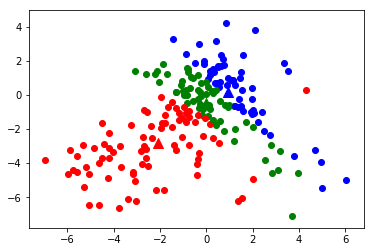

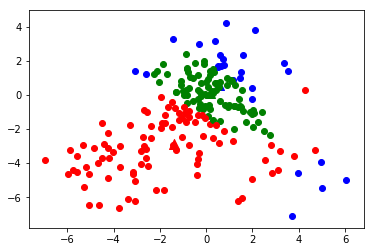

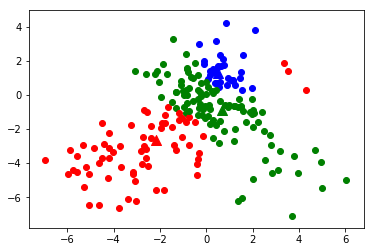

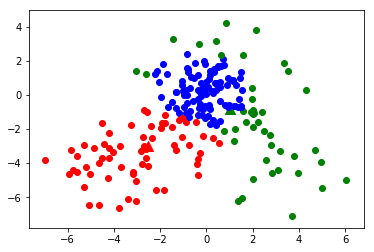

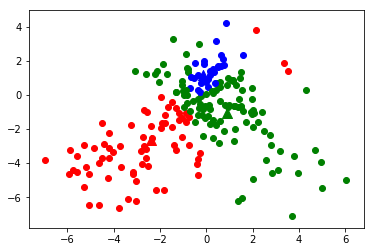

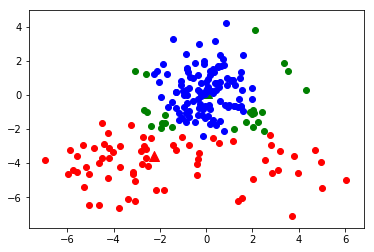

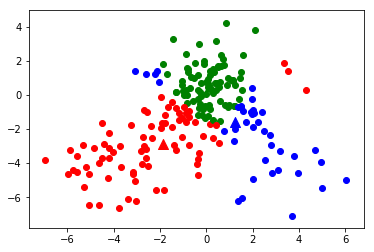

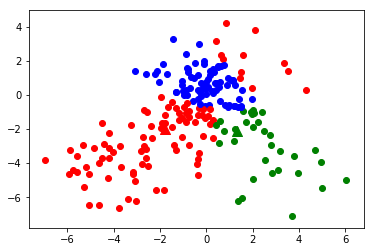

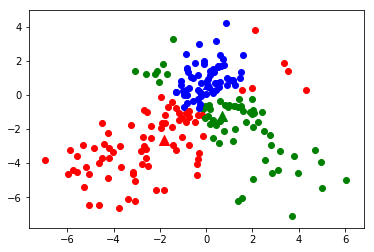

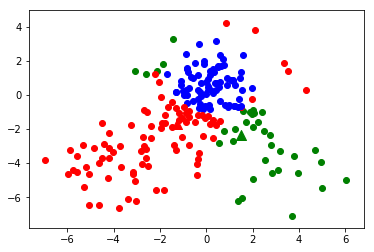

In [718]:
X = sample_gmm(200)

for max_iter in [2*(i+1)for i in range(10)]:
    gmm_gbbs = GMM_GIBBS(mu_s, lam_s, m_s, beta, nu_s, w_s, pi, alpha, max_iter)
    eta = gmm_gbbs.fit(X)
    cluster = np.argmax(eta, axis=1)
    colors = ["green", "blue", "red"]
    for k in range(mu_s.shape[0]):
        plt.scatter(gmm_gbbs.mu_s[k][0], gmm_gbbs.mu_s[k][1], color = colors[k], marker='^', s=100)
    
    for i in range(X.shape[0]):
        plt.scatter(X[i, 0], X[i, 1], color=colors[cluster[i]])
    plt.show()

40401

In [701]:
mesh

array([[-10. , -10. ],
       [-10. ,  -9.9],
       [-10. ,  -9.8],
       ...,
       [ 10. ,   9.8],
       [ 10. ,   9.9],
       [ 10. ,  10. ]])

In [640]:
print(np.linalg.inv(gmm_gbbs.lam_s[0]))

print(np.linalg.inv(gmm_gbbs.lam_s[1]))

print(np.linalg.inv(gmm_gbbs.lam_s[2]))

[[128.30724741 128.33545335]
 [128.33545335 128.38652926]]
[[99.48479855 99.53948954]
 [99.53948954 99.6352254 ]]
[[163.03287007 162.65279174]
 [162.65279174 162.30181451]]


## ガウス分布の学習 - 平均のみ未知 -

In [188]:
def draw_gauss(m = [0.5, -5], lam = [[2.0, 0.6], [0.6, 4]], title=""):
    x = np.linspace(-10,10,100) 
    y = np.linspace(-10,10,100) 
    X, Y = np.meshgrid(x,y) 
    pos = np.empty(X.shape + (2,)) 
    pos[:, :, 0] = X; pos[:, :, 1] = Y

    #Make a 3D plot 
    fig = plt.figure() 
    ax = Axes3D(fig)
    rv = stats.multivariate_normal(m.reshape(-1), lam)
    probs = rv.pdf(pos)
    ax.plot_wireframe(X, Y, probs)
    ax.set_xlabel('X') 
    ax.set_ylabel('Y') 
    ax.set_zlabel('prob') 
    ax.set_zlim(0, np.max(probs) * 1.1)
    plt.title(title)
    plt.show() 
    return

In [197]:
class Gauss_mu:
    '''平均が未知の多次元ガウス分布の学習
    '''
    def __init__(self, lam, m_mu, lam_mu):
        '''事前分布の初期パラメータを設定する
        inputs : lam, array(D * D)
                      m_mu, array(D*1)
                      lambda_mu, array(D * D)
        '''
        self.lam = np.array(lam)
        self.sigma = np.linalg.inv(lam)
        self.m_mu = np.array(m_mu)
        self.lam_mu = np.array(lam_mu)
        self.sigma_mu = np.linalg.inv(lam_mu)
        
    def fit(self, X):
        '''試行X後の事後分布によって事前分布を更新
        inputs : X, array(N*D)
        return : None
        '''
        lam_mu_ = self.lam_mu + X.shape[0] * self.lam
        tmp = np.dot(self.lam, np.sum(X, axis=0).reshape(-1, 1))
        tmp_ = np.dot(self.lam_mu, self.m_mu.T)
        self.m_mu = np.dot(np.linalg.inv(lam_mu_), (tmp +  tmp_)).T
        self.lam_mu = lam_mu_
        self.sigma_mu = np.linalg.inv(lam_mu_)
        return 
        
    def show_params(self, title=""):
        '''事後分布(事前分布)を可視化
        return : None
        '''
        draw_gauss(self.m_mu, self.sigma_mu)
        return
        
    def sampling(self, N):
        '''予測分布からのサンプリング
        inputs : N, int, N > 0
        return : array(N * D)
        '''
        draw_gauss(self.m_mu.reshape(-1), self.sigma+self.sigma_mu)
        return stats.multivariate_normal.rvs(self.m_mu.reshape(-1), self.sigma+self.sigma_mu, size=N)

before learning


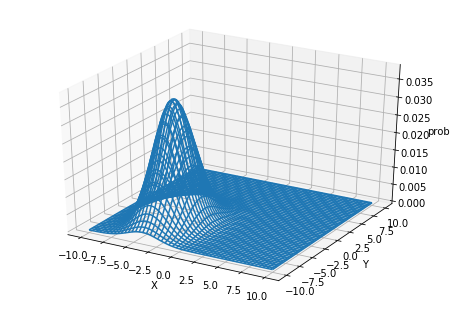

after 3 samples


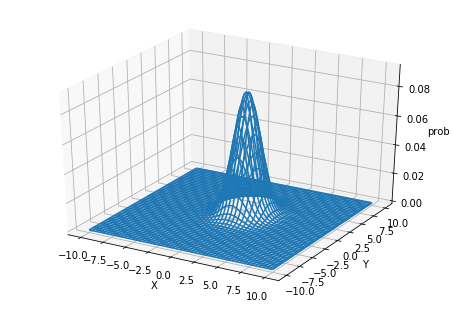

after 6 samples


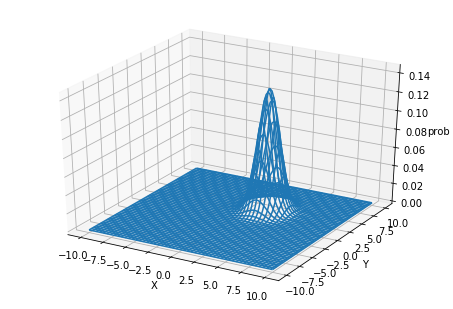

after 9 samples


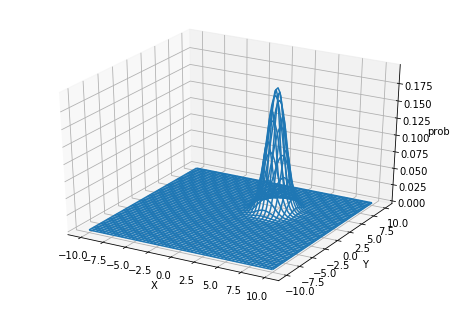

after 12 samples


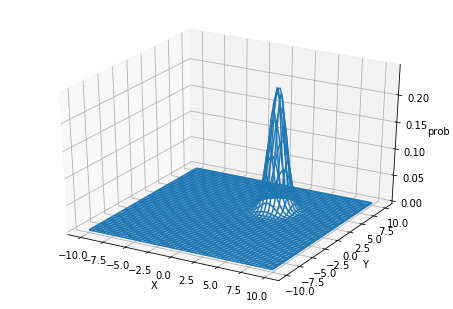

after 15 samples


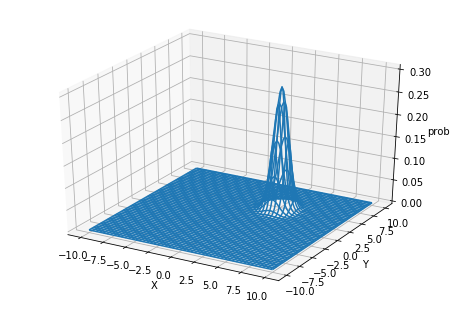

after 18 samples


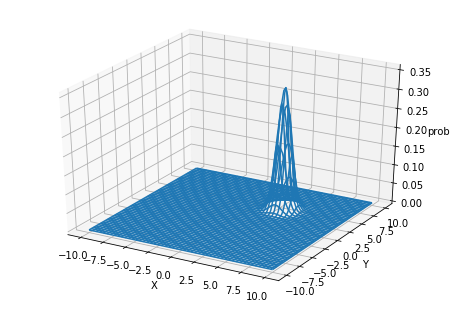

after 21 samples


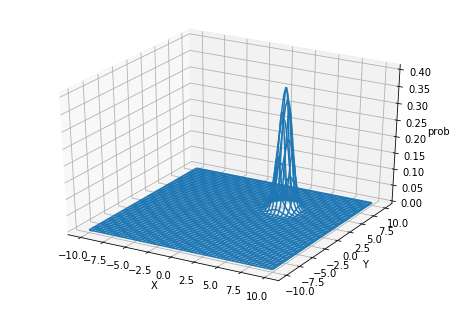

after 24 samples


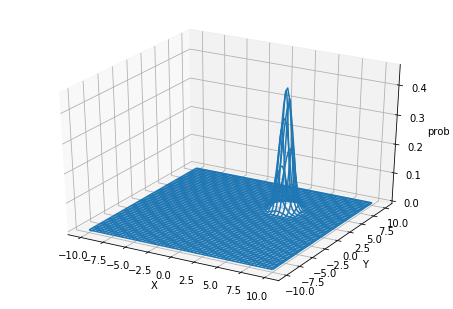

after 27 samples


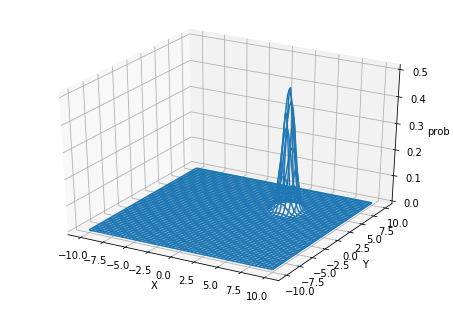

after 30 samples


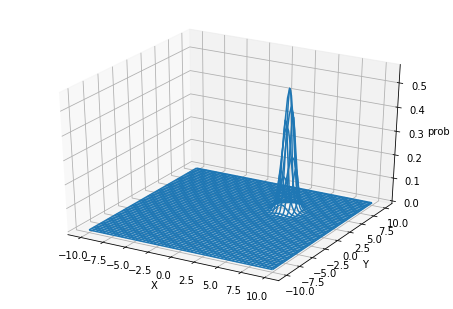

In [265]:
# 初期設定
sigma = np.array([[10, 0], [0, 10]], dtype = 'float64')
lam = np.linalg.inv(sigma)

m_mu = np.array([[-4, -4]], dtype = 'float64')
sigma_mu = np.array([[3, 0], [0, 7]], dtype = 'float64')
lam_mu = np.linalg.inv(sigma_mu)

gauss_mu = Gauss_mu(lam, m_mu, lam_mu)

# # 学習前
print("before learning")
gauss_mu.show_params()

# # 予測分布
# sampled = gauss_mu.sampling(100)
    
N = 3
true_m = np.array([[4, 4]], dtype = 'float64')
true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
for i in range(10):
    print(f"after {N*(i+1)} samples")
    # 真の分布からサンプリング
    X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=N)
    
    # 事後分布の更新
    gauss_mu.fit(X)
    gauss_mu.show_params()
    
#     # 予測分布
#     sampled = gauss_mu.sampling(100)

## ガウス分布の学習 - 精度のみ未知 -

In [253]:
def multi_t_rvs(mu, sigma, nu, N):
    '''
    Output: Produce N samples of d-dimension t distribution
    Input:
    mu = mean (d dimensional numpy array or scalar)
    sigma = scale matrix (dxd numpy array)
    nu = degrees of freedom
    N = # of samples to produce
    '''
    D = sigma.shape[0]
    g = np.tile(np.random.gamma(nu/2., 2./nu, N), reps=(D, 1)).T
    Z = np.random.multivariate_normal(np.zeros(D), sigma, N)
    return mu + Z/np.sqrt(g)

In [384]:
def show_img(X, sampled, title="", save_path=None):
    '''2次元の標本を散布図で比較する
    '''
    plt.scatter(X[:, 0], X[:, 1], color="blue", label="true")
    plt.scatter(sampled[:, 0], sampled[:, 1], color="orange", label="pred")
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.legend()
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
    plt.show()
    return

In [385]:
class Gauss_lam:
    '''平均が未知の多次元ガウス分布の学習
    '''
    def __init__(self, mu, lam_nu, lam_w):
        '''事前分布の初期パラメータを設定する
        inputs : mu, array(D * 1)
                      lam_nu, float, lam_nu > D -1
                      lam_w, array(D * D), lam_w > 0
        '''
        self.mu = np.array(mu)
        self.lam_nu = lam_nu
        self.lam_w = np.array(lam_w)
        self.lam_w_inv = np.linalg.inv(lam_w)
        self.D = lam_w.shape[0]
        
    def fit(self, X):
        '''試行X後の事後分布によって事前分布を更新
        inputs : X, array(N*D)
        return : None
        '''
        self.lam_nu += X.shape[0]
        tmp = X - np.tile(self.mu, reps=(X.shape[0], 1))
        tmp_ = np.zeros((self.D, self.D))
        for i in range(X.shape[0]):
            tmp_ += np.dot(tmp[i, :].reshape(self.D, 1), tmp[i, :].reshape(1, self.D))
        self.lam_w_inv += tmp_
        self.lam_w = np.linalg.inv(self.lam_w_inv)
        return 
        
    def show_params(self, title=""):
        '''事後分布(事前分布)を可視化
        return : None
        '''
        lams = stats.wishart.rvs(df=self.lam_nu, scale = self.lam_w, size=1000)
        e_lam = np.mean(lams, axis=0)
        return e_lam
        
    def sampling(self, N):
        '''予測分布からのサンプリング
        inputs : N, int, N > 0
        return : array(N * D)
        '''
        mu_s = self.mu
        nu_s = 1 - self.D + self.lam_nu
        sigma_s = (1/nu_s)*self.lam_w_inv
        return multi_t_rvs(mu_s,  sigma_s, nu_s, N)

before learning


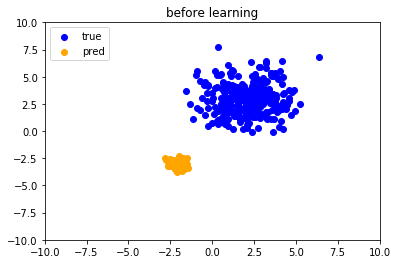

after 2 samples


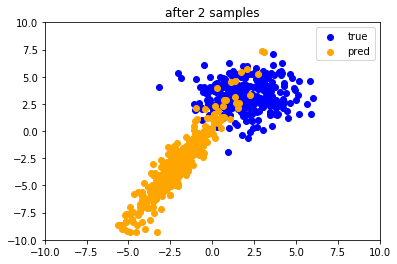

after 4 samples


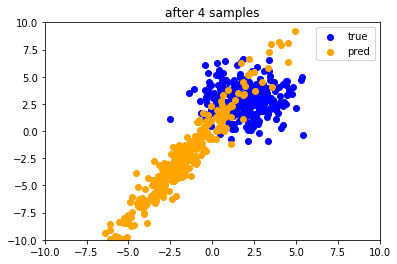

after 6 samples


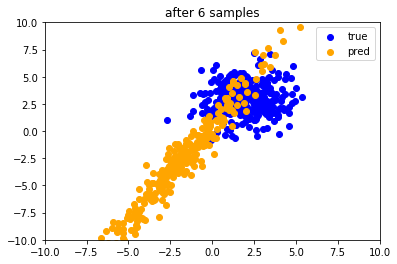

after 8 samples


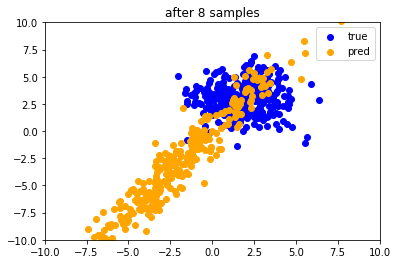

after 10 samples


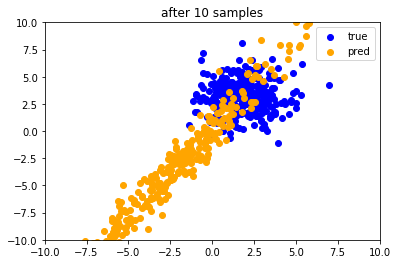

after 12 samples


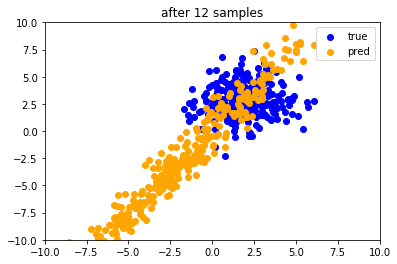

after 14 samples


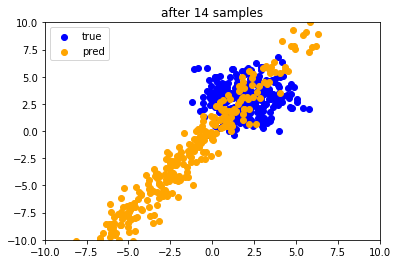

after 16 samples


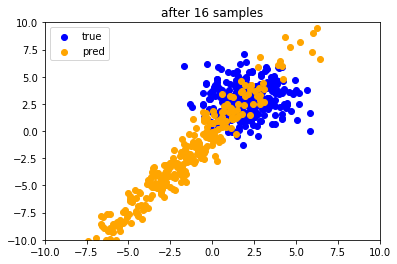

after 18 samples


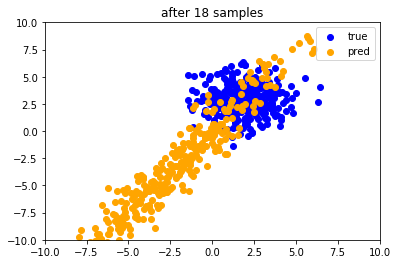

after 20 samples


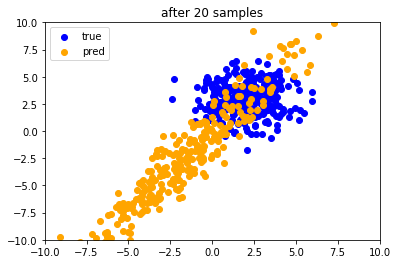

after 22 samples


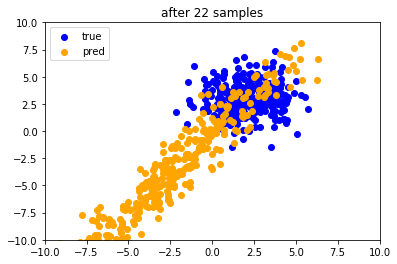

after 24 samples


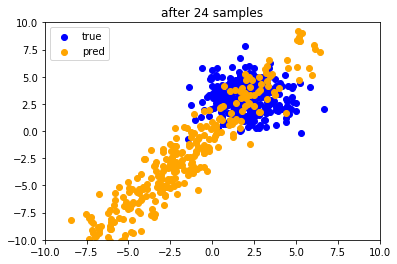

after 26 samples


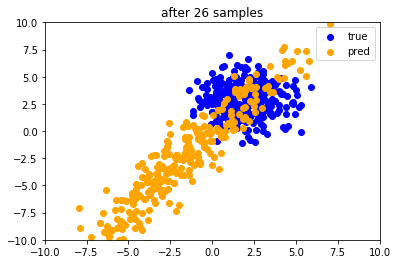

after 28 samples


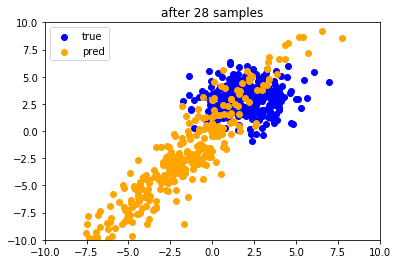

after 30 samples


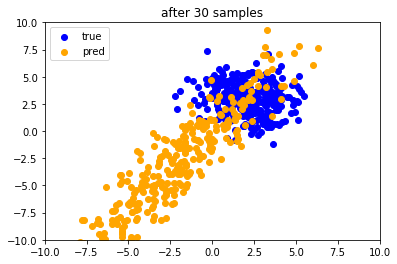

after 32 samples


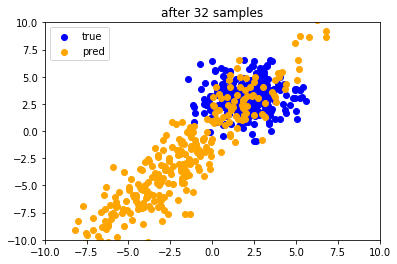

after 34 samples


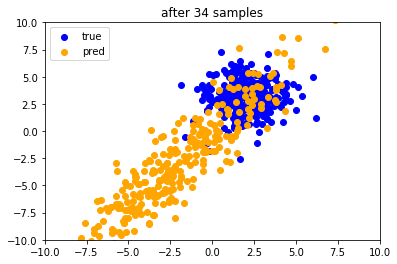

after 36 samples


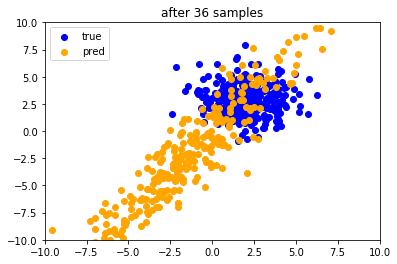

after 38 samples


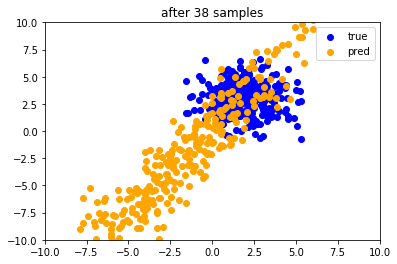

after 40 samples


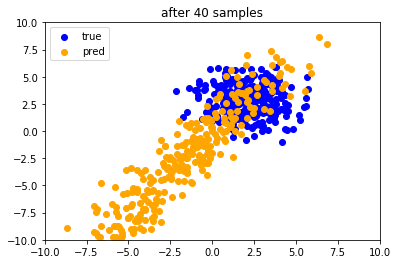

after 42 samples


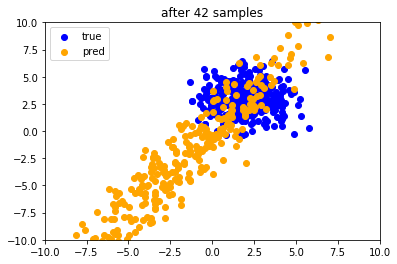

after 44 samples


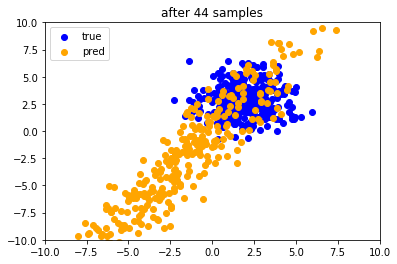

after 46 samples


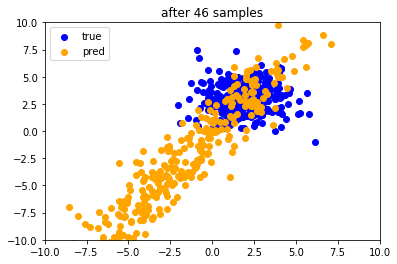

after 48 samples


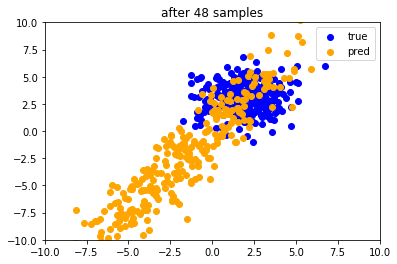

after 50 samples


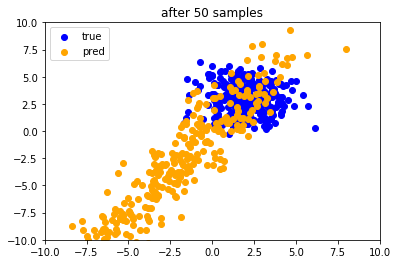

after 52 samples


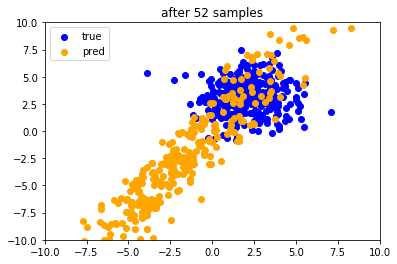

after 54 samples


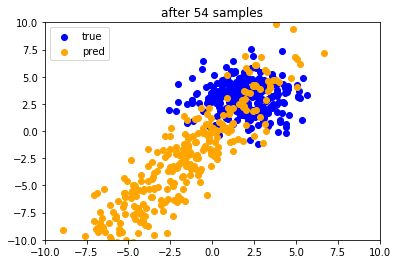

after 56 samples


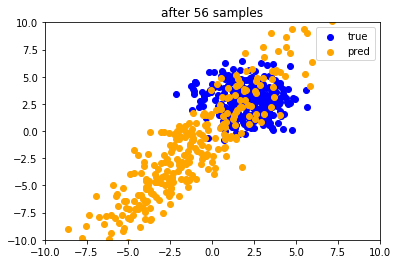

after 58 samples


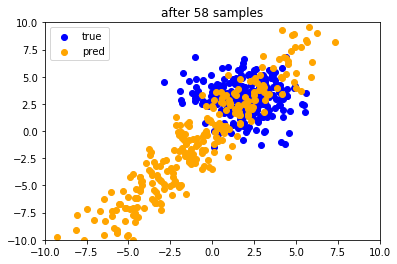

after 60 samples


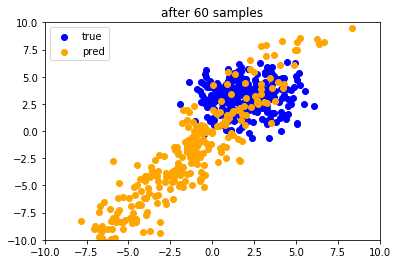

In [393]:
# 初期設定
mu = np.array([[-2, -3]], dtype="float64")

lam_nu = 10
lam_w = np.array([[3, 0], [0, 3]], dtype = 'float64')

gauss_lam = Gauss_lam(mu, lam_nu, lam_w)

# 学習前
print("before learning")
# print(gauss_lam.show_params())

# 予測分布
img_num = 0
X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=300)
sampled = gauss_lam.sampling(300)
show_img(X, sampled, "before learning", IMG_PATH+f"{img_num}.png")


N = 2
max_iter = 30
true_m = np.array([[2, 3]], dtype = 'float64')
true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
true_lam = np.linalg.inv(true_sigma)
for i in range(max_iter):
    print(f"after {N*(i+1)} samples")
    # 真の分布からサンプリング
    X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=N)
    
    # 事後分布の更新
    gauss_lam.fit(X)
#     print(gauss_lam.show_params())
    
    # 予測分布
    img_num += 1
    X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=300)
    sampled = gauss_lam.sampling(300)
    show_img(X, sampled, f"after {N*(i+1)} samples", IMG_PATH+f"{img_num}.png")
ims = []
for i in range(max_iter+1):
    ims.append(Image.open(IMG_PATH+f"{i}.png"))
ims[0].save(IMG_PATH+"out.gif", save_all=True, append_images=ims[1:])

## ガウス分布の学習 -両方未知- 

In [429]:
class Gauss:
    '''平均と精度が未知の多次元ガウス分布の学習
    '''
    def __init__(self, mu, lam, 
                                    mu_m, mu_beta,
                                    lam_nu, lam_w):
        '''事前分布の初期パラメータを設定する
        inputs : mu, array(D * 1)
                      lam, array(D * D), lam > 0
                      mu_m, array(D * 1)
                      mu_beta, float, mu_beta > 0
                      lam_nu, float, lam_nu > D -1
                      lam_w, array(D * D), lam_w > 0
        '''
        # 観測モデル
        self.mu = np.array(mu)
        self.lam = np.array(lam)
        self.sigma = np.linalg.inv(self.lam)
        # 事前分布：ガウス
        self.mu_m = np.array(mu_m)
        self.mu_beta = mu_beta
        # 事前分布:ウィシャート
        self.lam_nu = lam_nu
        self.lam_w = np.array(lam_w)
        self.lam_w_inv = np.linalg.inv(lam_w)
        
        self.D = lam_w.shape[0]
        
    def fit(self, X):
        '''試行X後の事後分布によって事前分布を更新
        inputs : X, array(N*D)
        return : None
        '''
        # 事後分布：ガウス
        mu_beta_old = float(self.mu_beta)
        self.mu_beta += X.shape[0]
        mu_m_old = np.array(self.mu_m)
        self.mu_m = (np.sum(X, axis=0) + mu_beta_old * mu_m_old) / (self.mu_beta)
        # 事後分布：ウィシャート
        self.lam_nu += X.shape[0]
        tmp_ = np.zeros((self.D, self.D))
        for i in range(X.shape[0]):
            tmp_ += np.dot(X[i, :].reshape(self.D, 1), X[i, :].reshape(1, self.D))
        self.lam_w_inv += (tmp_ + mu_beta_old * np.dot(mu_m_old.T, mu_m_old) 
                                        - self.mu_beta * np.dot(self.mu_m .T, self.mu_m))
        self.lam_w = np.linalg.inv(self.lam_w_inv)
        return 
        
    def show_params(self, title=""):
        '''事後分布(事前分布)を可視化
        return : None
        '''
        lams = stats.wishart.rvs(df=self.lam_nu, scale = self.lam_w, size=1000)
        e_lam = np.mean(lams, axis=0)
        draw_gauss(self.mu_m, np.linalg.inv(e_lam)/self.mu_beta)
        return e_lam
        
    def sampling(self, N):
        '''予測分布からのサンプリング
        inputs : N, int, N > 0
        return : array(N * D)
        '''
        mu_s = self.mu_m
        nu_s = 1 - self.D + self.lam_nu
        sigma_s = self.lam_w_inv * (1 + self.mu_beta) / (nu_s * self.mu_beta)
        return multi_t_rvs(mu_s,  sigma_s, nu_s, N)

before learning


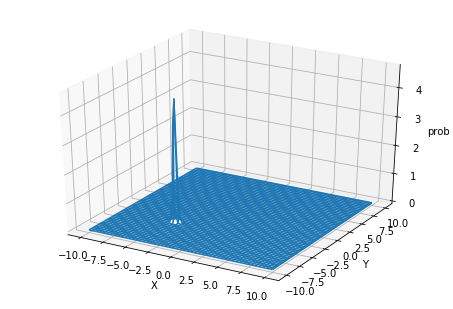

[[29.64985576 -0.12097831]
 [-0.12097831 29.92916949]]


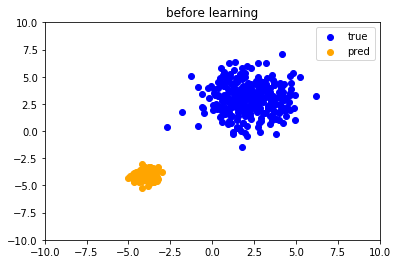

after 2 samples


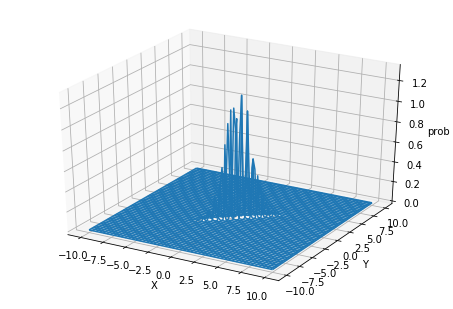

[[ 15.28001068 -17.86836501]
 [-17.86836501  21.3888849 ]]


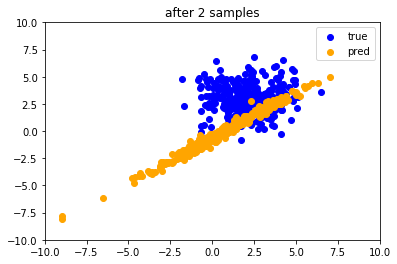

after 4 samples


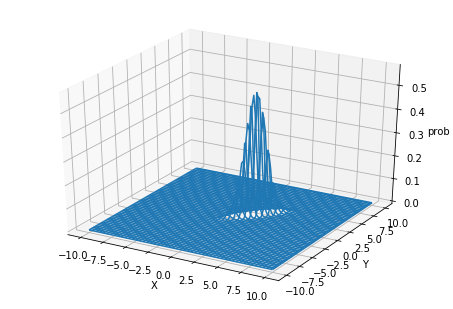

[[ 1.53881178 -1.23589922]
 [-1.23589922  1.28276312]]


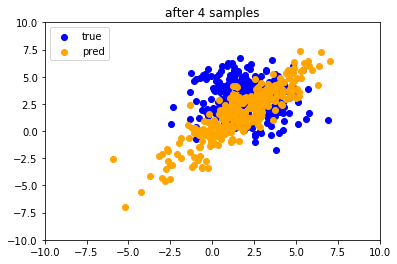

after 6 samples


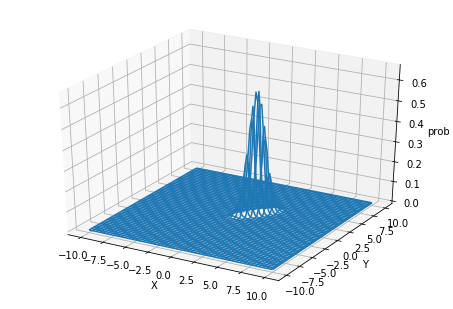

[[ 1.07017037 -0.71272678]
 [-0.71272678  0.75204399]]


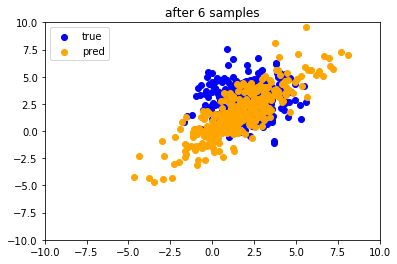

after 8 samples


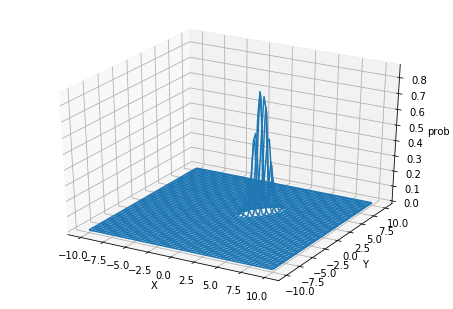

[[ 1.15031069 -0.7412458 ]
 [-0.7412458   0.75323349]]


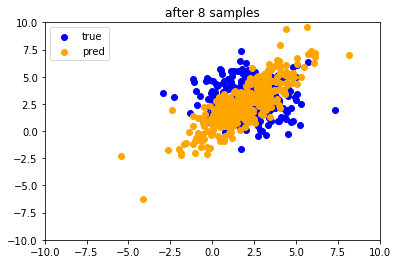

after 10 samples


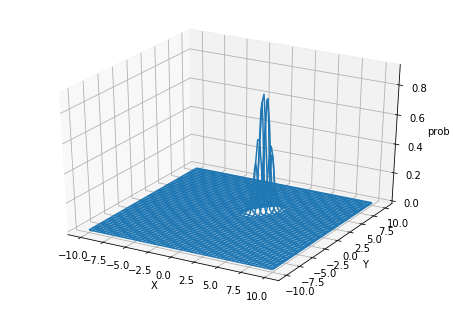

[[ 0.85325573 -0.49806975]
 [-0.49806975  0.56513996]]


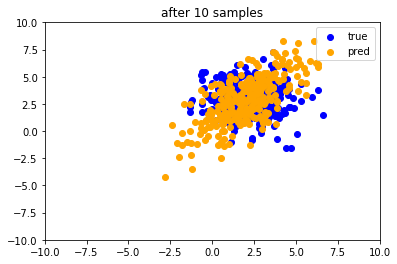

after 12 samples


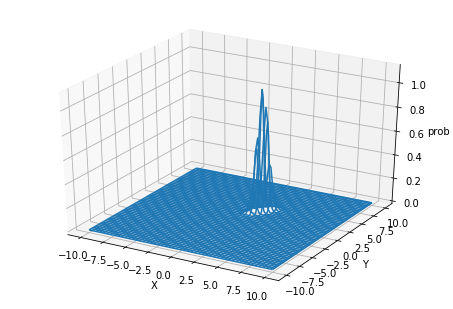

[[ 0.86099235 -0.49329159]
 [-0.49329159  0.57764274]]


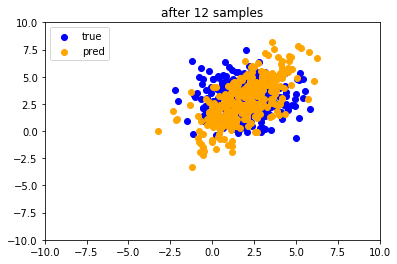

after 14 samples


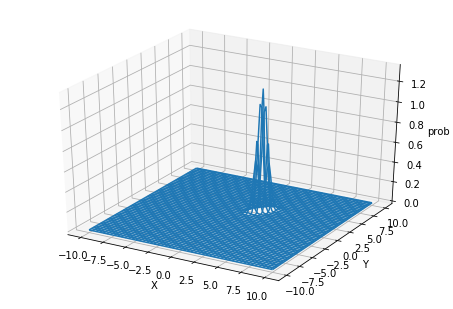

[[ 0.80652538 -0.46985592]
 [-0.46985592  0.59324187]]


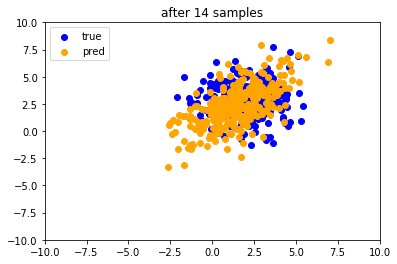

after 16 samples


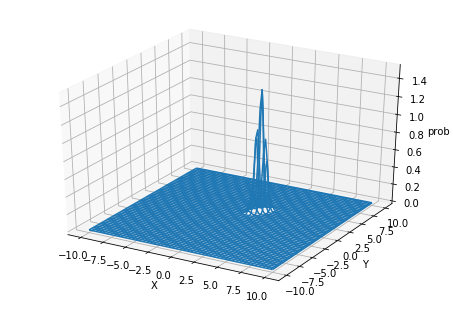

[[ 0.84175307 -0.46400846]
 [-0.46400846  0.57563853]]


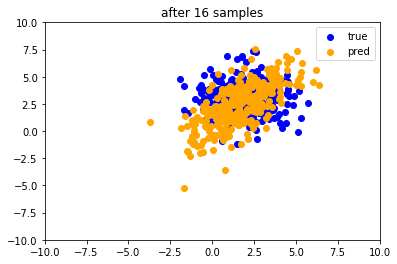

after 18 samples


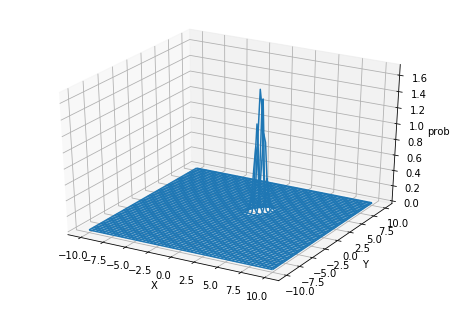

[[ 0.79922811 -0.42310438]
 [-0.42310438  0.56491456]]


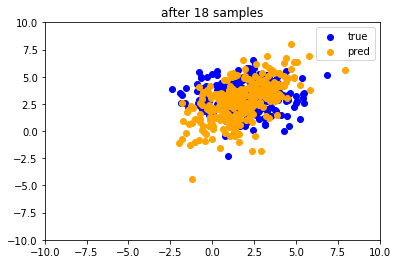

after 20 samples


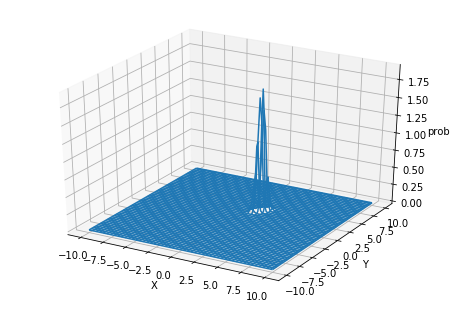

[[ 0.83453387 -0.42984013]
 [-0.42984013  0.57308137]]


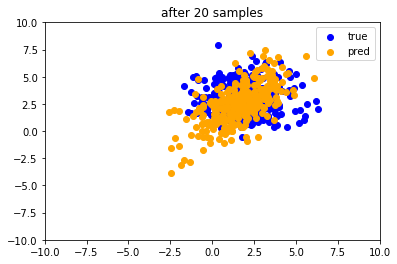

after 22 samples


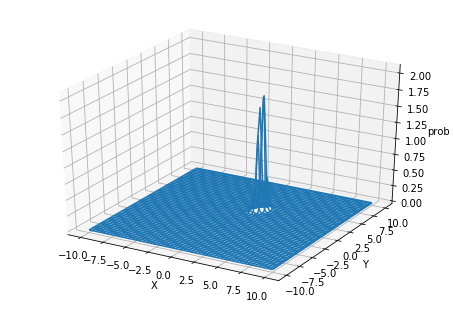

[[ 0.8546103  -0.43641518]
 [-0.43641518  0.5808926 ]]


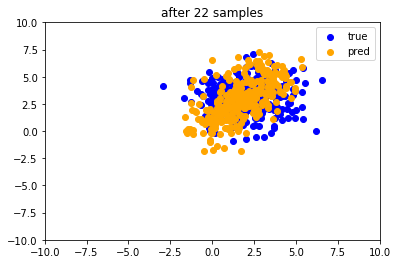

after 24 samples


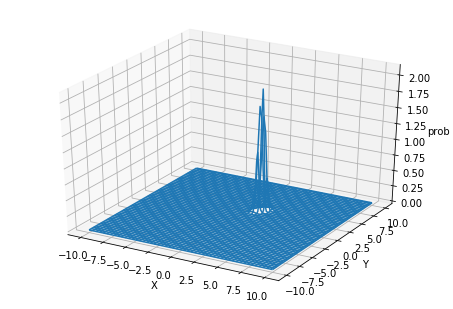

[[ 0.66680289 -0.30156991]
 [-0.30156991  0.50117505]]


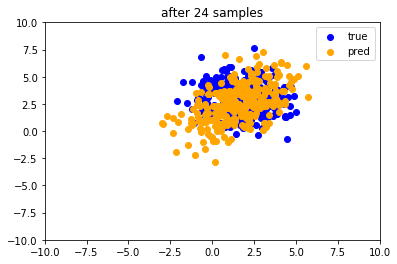

after 26 samples


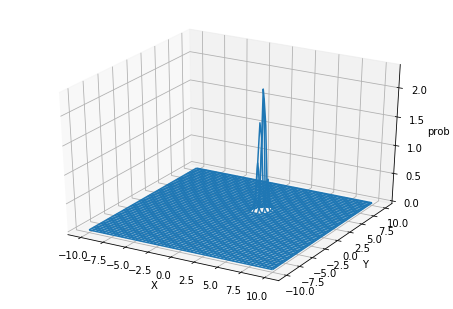

[[ 0.70535666 -0.31655695]
 [-0.31655695  0.52076088]]


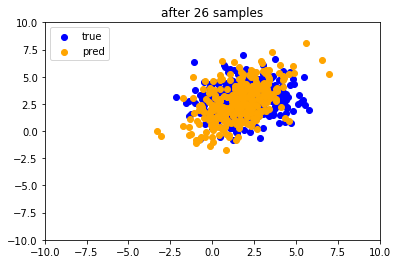

after 28 samples


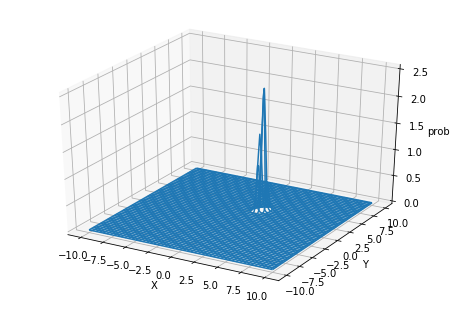

[[ 0.70991345 -0.30585702]
 [-0.30585702  0.5302528 ]]


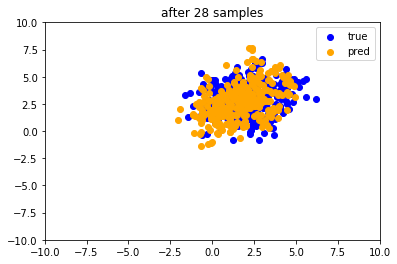

after 30 samples


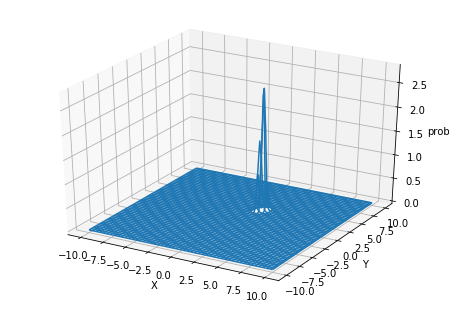

[[ 0.73873191 -0.31855781]
 [-0.31855781  0.55380053]]


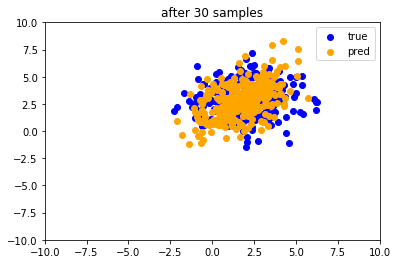

after 32 samples


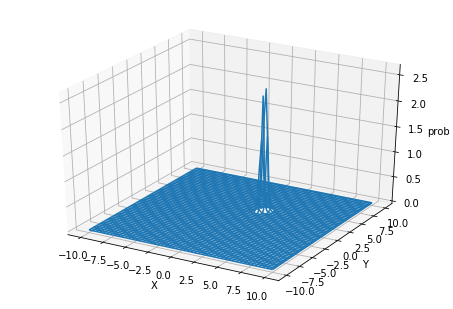

[[ 0.57693831 -0.22947318]
 [-0.22947318  0.52867905]]


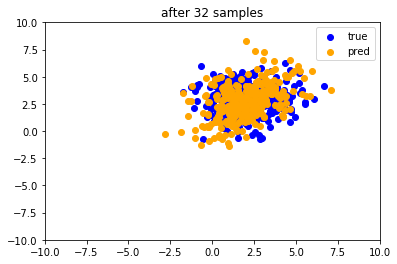

after 34 samples


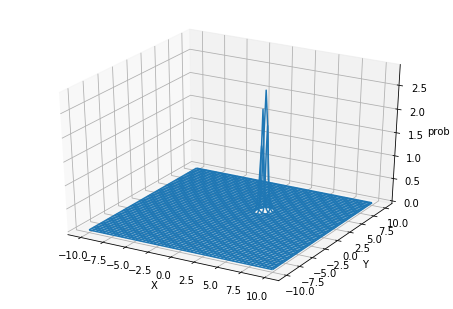

[[ 0.59355314 -0.23783548]
 [-0.23783548  0.54275292]]


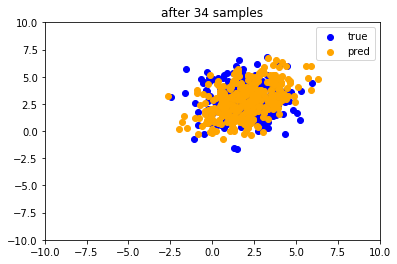

after 36 samples


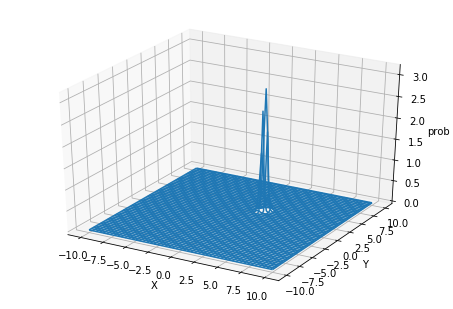

[[ 0.62093664 -0.25348846]
 [-0.25348846  0.56165637]]


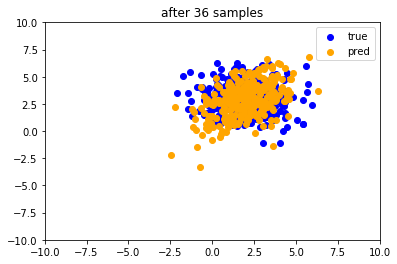

after 38 samples


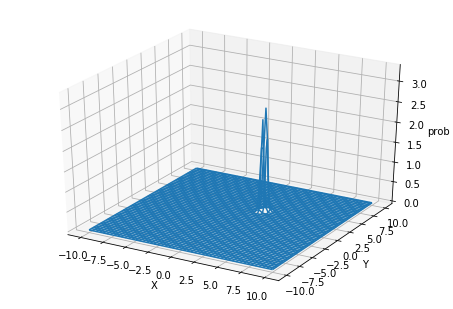

[[ 0.57420152 -0.18041556]
 [-0.18041556  0.5040271 ]]


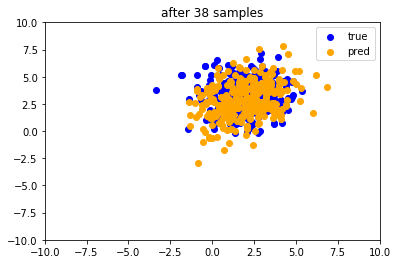

after 40 samples


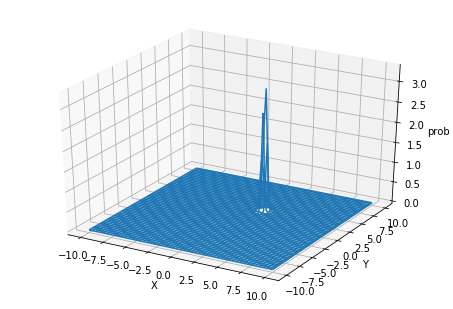

[[ 0.57333316 -0.16058512]
 [-0.16058512  0.48557959]]


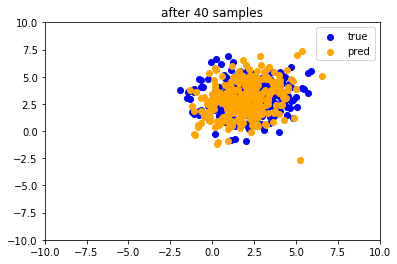

after 42 samples


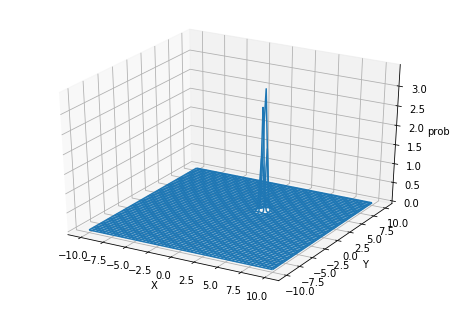

[[ 0.58848875 -0.16010147]
 [-0.16010147  0.49875119]]


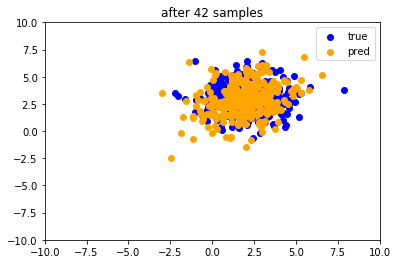

after 44 samples


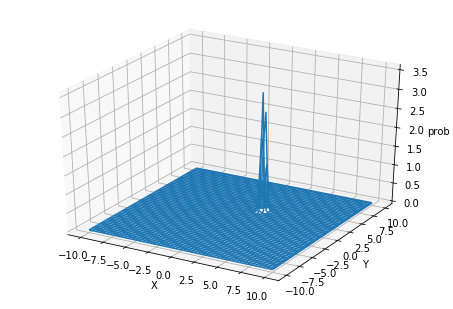

[[ 0.57377595 -0.1554684 ]
 [-0.1554684   0.49876179]]


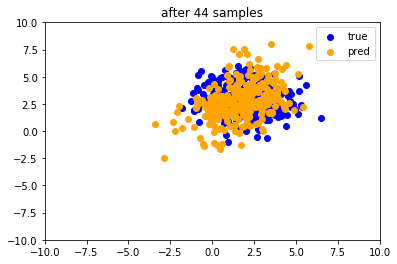

after 46 samples


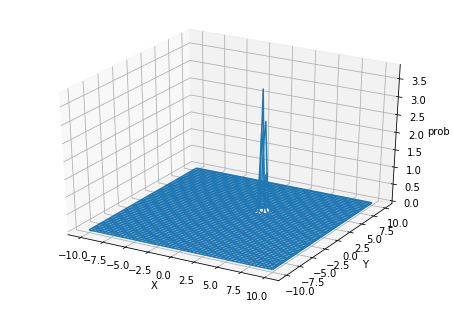

[[ 0.59093069 -0.15808578]
 [-0.15808578  0.51469222]]


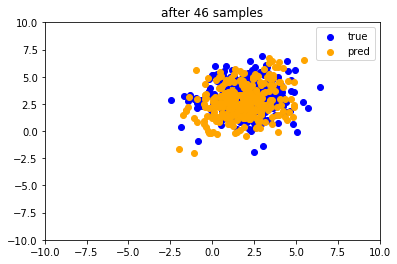

after 48 samples


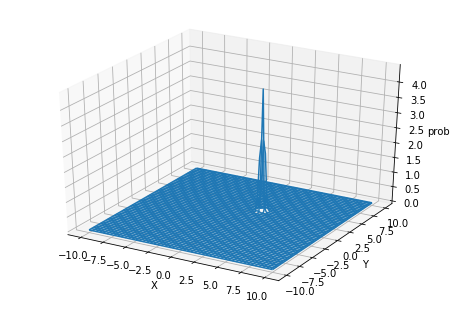

[[ 0.55916699 -0.15866048]
 [-0.15866048  0.53090784]]


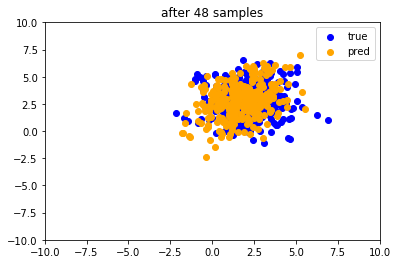

after 50 samples


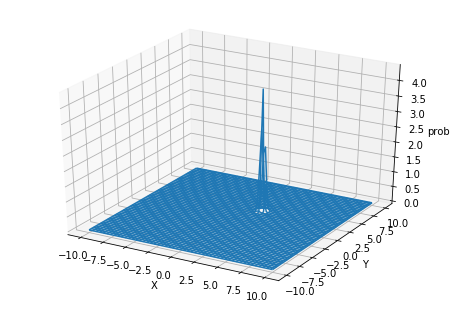

[[ 0.55433444 -0.14584586]
 [-0.14584586  0.53968399]]


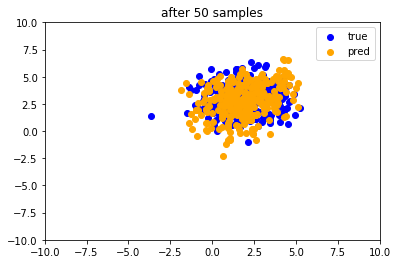

after 52 samples


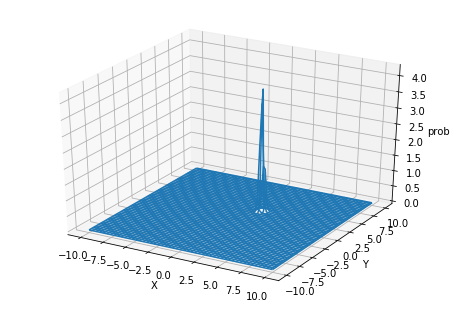

[[ 0.51986259 -0.12706985]
 [-0.12706985  0.51602527]]


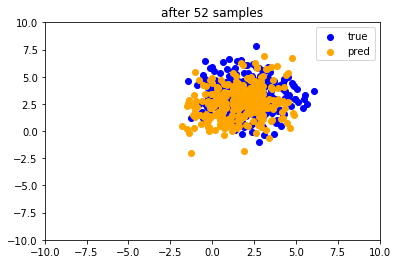

after 54 samples


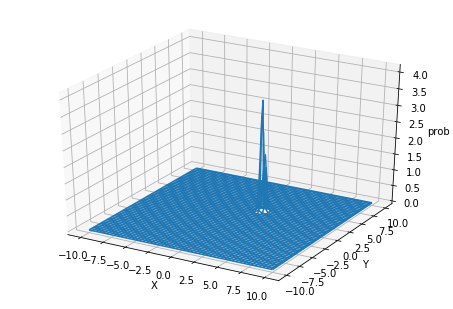

[[ 0.48281668 -0.12114255]
 [-0.12114255  0.52493367]]


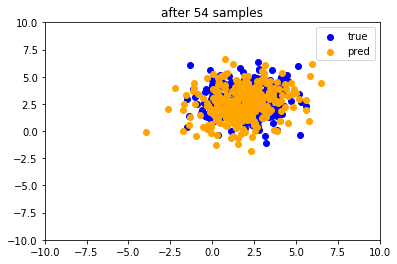

after 56 samples


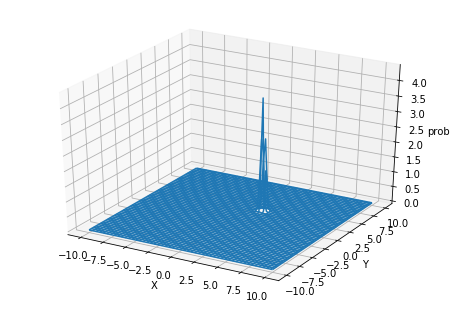

[[ 0.48995514 -0.11517635]
 [-0.11517635  0.52224206]]


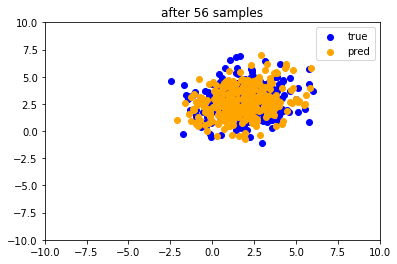

after 58 samples


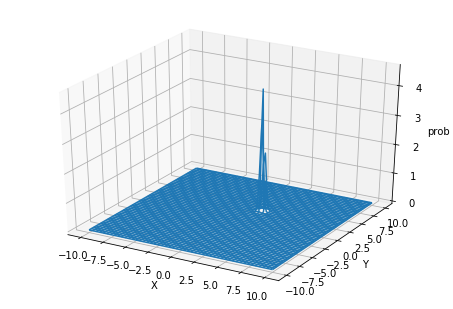

[[ 0.5031637  -0.1311313 ]
 [-0.1311313   0.53701959]]


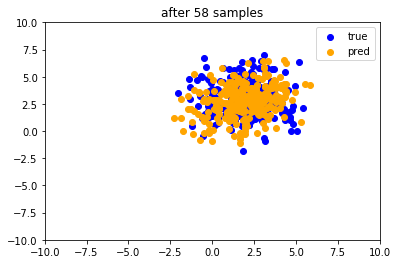

after 60 samples


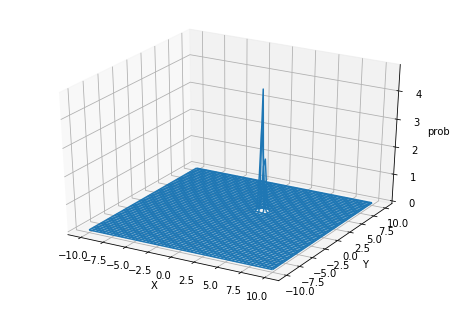

[[ 0.4942988  -0.11569871]
 [-0.11569871  0.54187717]]


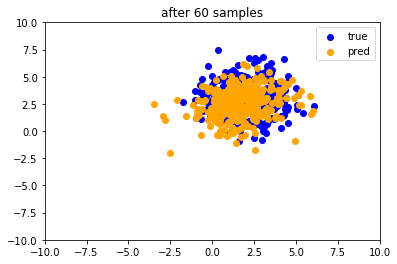

In [430]:
# 初期設定
mu = np.array([[-2, -3]], dtype="float64")
sigma = np.array([[10, 0], [0, 10]], dtype = 'float64')
lam = np.linalg.inv(sigma)

m_mu = np.array([[-4, -4]], dtype = 'float64')
m_beta = 1
sigma_mu = np.array([[3, 0], [0, 7]], dtype = 'float64')
lam_mu = np.linalg.inv(sigma_mu)

lam_nu = 10
lam_w = np.array([[3, 0], [0, 3]], dtype = 'float64')

gauss = Gauss(mu, lam, 
                          m_mu, m_beta,
                          lam_nu, lam_w)

# # 学習前
print("before learning")
# print(gauss.show_params())

# 予測分布
img_num = 0
X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=300)
sampled = gauss.sampling(300)
show_img(X, sampled, "before learning", IMG_PATH+f"{img_num}.png")


N = 2
max_iter = 30
true_m = np.array([[2, 3]], dtype = 'float64')
true_sigma = np.array([[2, 0], [0, 2]], dtype = 'float64')
true_lam = np.linalg.inv(true_sigma)
for i in range(max_iter):
    print(f"after {N*(i+1)} samples")
    # 真の分布からサンプリング
    X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=N)
    
    # 事後分布の更新
    gauss.fit(X)
#     print(gauss.show_params())
    
    # 予測分布
    img_num += 1
    X = stats.multivariate_normal.rvs(true_m.reshape(-1), true_sigma, size=300)
    sampled = gauss.sampling(300)
    show_img(X, sampled, f"after {N*(i+1)} samples", IMG_PATH+f"{img_num}.png")
ims = []
for i in range(max_iter+1):
    ims.append(Image.open(IMG_PATH+f"{i}.png"))
ims[0].save(IMG_PATH+"out.gif", save_all=True, append_images=ims[1:], duration=60)